In [4]:
# !pip install scikit-learn==0.24.2
!pip install scikit-optimize
#!pip install git+https://github.com/scikit-optimize/scikit-optimize.git

In [5]:
# Checking that everything is correct with skopt (0.9.dev0) and sklearn 
from skopt import __version__
print(__version__)
from sklearn import __version__
print(__version__)

0.9.0
1.1.1


# DECISION TREE HYPER-PARAMETERS. TUNING DECISION TREES

- **max_depth : int or None, optional (default=None)**
    The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples. Ignored if max_leaf_nodes is not None.
    
- **min_samples_split : int, optional (default=2)**
    The minimum number of samples required to split an internal node.

- There are more hyper-parameters: 
  - https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html
  - https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html



First, data is loaded, inputs go to X, outputs to y.

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import fetch_california_housing
from scipy.stats import sem

housing = fetch_california_housing()
print(housing.feature_names)
print(housing.target_names)

X = housing.data
y = housing.target


['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']
['MedHouseVal']


## COMBINING HYPER-PARAMETER TUNING AND MODEL EVALUATION

The combination of model evaluation and hyper-parameter tuning can be understood as an external loop (outer) that trains a model and tests the model, and an internal loop (inner), where the training process consists on looking for the best hyper-parameters, and then obtaining the model with those best hyper-parameters.

First, we are going to use **Holdout** (train/test) for model evaluation (external loop or **outer**), and **3-fold crossvalidation** for hyper-parameter tuning (internal loop or **inner**). Hyper-parameters will be adjusted with **Gridsearch**.

#### GRIDSEARCH

First of all, let's define our our python function for RMSE

In [14]:
def rmse(y_test, y_test_pred):
  """ This is my computation of Root Mean Squared Error """
  return np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))

In [15]:
from sklearn.model_selection import train_test_split

# Holdout for model evaluation. 33% of available data for test
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.33, random_state=42)

First, let's remember RMSE with default hyper-parameteres

In [16]:
from sklearn import metrics
from sklearn.tree import DecisionTreeRegressor

regr = DecisionTreeRegressor()
np.random.seed(42)
regr.fit(X=X_train, y=y_train)
print(f"RMSE of tree with default hyper-pars: {rmse(y_test, regr.predict(X=X_test))}")


RMSE of tree with default hyper-pars: 0.7389833060012664


In [17]:
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.model_selection import KFold


# Search space
param_grid = {'max_depth': list(range(2,16,2)),
              'min_samples_split': list(range(2,16,2))}

inner = KFold(n_splits=3, shuffle=True, random_state=42)

# Definition of a 2-step process that self-adjusts 2 hyperpars
regr = GridSearchCV(DecisionTreeRegressor(), 
                   param_grid,
                   scoring='neg_mean_squared_error',
                   cv=inner, 
                   n_jobs=1, verbose=1)

# Train the self-adjusting process
np.random.seed(42)
regr.fit(X=X_train, y=y_train)

# At this point, regr contains the model with the best hyper-parameters found by gridsearch
# and trained on the complete X_train

Fitting 3 folds for each of 49 candidates, totalling 147 fits


GridSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=True),
             estimator=DecisionTreeRegressor(), n_jobs=1,
             param_grid={'max_depth': [2, 4, 6, 8, 10, 12, 14],
                         'min_samples_split': [2, 4, 6, 8, 10, 12, 14]},
             scoring='neg_mean_squared_error', verbose=1)

In [18]:
# Now, the performance of regr is computed on the test partition

print(f"RMSE of tree with hyper-parameter tuning (grid-search): {rmse(y_test, regr.predict(X=X_test))}")

RMSE of tree with hyper-parameter tuning (grid-search): 0.6647688056188821


Let's see the best hyper-parameters and their score (MSE). We can see that they are not at the extreme.

In [19]:
regr.best_params_, -regr.best_score_

({'max_depth': 8, 'min_samples_split': 14}, 0.44782374157784616)

#### RANDOMIZED SEARCH

Now, let's use **Randomized Search** instead of gridsearch. Only 20 hyper-parameter value combinations will be tried (budget=20)

In [20]:
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn import metrics

# Search space
param_grid = {'max_depth': list(range(2,16,2)),
              'min_samples_split': list(range(2,16,2))}

# Inner evaluation
inner = KFold(n_splits=3, shuffle=True, random_state=42)

budget = 20
regr = RandomizedSearchCV(DecisionTreeRegressor(), 
                         param_grid,
                         scoring='neg_mean_squared_error',
                         cv=inner, 
                         n_jobs=1, verbose=1,
                         n_iter=budget
                        )
np.random.seed(42)
regr.fit(X=X_train, y=y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


RandomizedSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=True),
                   estimator=DecisionTreeRegressor(), n_iter=20, n_jobs=1,
                   param_distributions={'max_depth': [2, 4, 6, 8, 10, 12, 14],
                                        'min_samples_split': [2, 4, 6, 8, 10,
                                                              12, 14]},
                   scoring='neg_mean_squared_error', verbose=1)

In [21]:
# Now, the performance of regr is computed on the test partition

print(f"RMSE of tree with hyper-parameter tuning (random search): {rmse(y_test, regr.predict(X=X_test))}")

RMSE of tree with hyper-parameter tuning (random search): 0.6640044054767447


In [22]:
regr.best_params_, -regr.best_score_

({'min_samples_split': 12, 'max_depth': 8}, 0.4452664287620658)

For **Randomized Search**, we can define the search space with statistical distributions, rather than using particular values as we did before. Below you can see how to use a uniform distribution on integers between 2 and 16 by means of *randint*. For continuous hyper-parameters we could use continuous distributions such as *uniform* or *expon* (exponential).

In [23]:
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn import metrics


from scipy.stats import uniform, expon
from scipy.stats import randint as sp_randint

# Search space with integer uniform distributions
param_grid = {'max_depth': sp_randint(2,16),
              'min_samples_split': sp_randint(2,16)}

inner = KFold(n_splits=3, shuffle=True, random_state=42)

budget = 20
regr = RandomizedSearchCV(DecisionTreeRegressor(), 
                         param_grid,
                         scoring='neg_mean_squared_error',
                         cv=inner, 
                         n_jobs=1, verbose=1,
                         n_iter=budget
                        )

np.random.seed(42)
regr.fit(X=X_train, y=y_train)

# At this point, regr contains the model with the best hyper-parameters found by gridsearch
# and trained on the complete X_train

Fitting 3 folds for each of 20 candidates, totalling 60 fits


RandomizedSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=True),
                   estimator=DecisionTreeRegressor(), n_iter=20, n_jobs=1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001EAA2A8DDC0>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001EAA29C9820>},
                   scoring='neg_mean_squared_error', verbose=1)

In [24]:
# Now, the performance of regr is computed on the test partition

print(f"RMSE of tree with hyper-parameter tuning (random search II): {rmse(y_test, regr.predict(X=X_test))}")

RMSE of tree with hyper-parameter tuning (random search II): 0.6640044054767447


In [25]:
regr.best_params_, -regr.best_score_

({'max_depth': 8, 'min_samples_split': 12}, 0.4483635388476918)

What if we wanted to do **model evaluation with 5-fold crossvalidation** and **hyper-parameter tuning with 3-fold crossvalidation**? This is called nested crossvalidation (https://scikit-learn.org/stable/auto_examples/model_selection/plot_nested_cross_validation_iris.html). There is an external loop (for evaluating models) and an internal loop (for hyper-parameter tuning).

In [26]:
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn import metrics

# random_state=0 for reproducibility
# Evaluation of model (outer loop)
outer = KFold(n_splits=5, shuffle=True, random_state=42)


from scipy.stats import uniform, expon

# Search space
param_grid = {'max_depth': list(range(2,16,2)),
              'min_samples_split': list(range(2,16,2))}

inner = KFold(n_splits=3, shuffle=True, random_state=42)

budget = 20
# This is the internal 3-fold crossvalidation for hyper-parameter tuning
regr = RandomizedSearchCV(DecisionTreeRegressor(), 
                         param_grid,
                         scoring='neg_mean_squared_error',
                         # 3-fold for hyper-parameter tuning
                         cv=inner, 
                         n_jobs=1, verbose=1,
                         n_iter=budget
                        )

# This is the external 5-fold crossvalidation for model evaluation
# Notice that regr is the model resulting of hyper-parameter tuning
np.random.seed(42)

# For sklearn, higher scores are better. Given that MSE is an error (smaller is better), the corresponding score is -MSE
scores = -cross_val_score(regr, 
                            X, y, 
                            scoring='neg_mean_squared_error', 
                            cv = outer)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits


In [27]:
print(scores)
# The score was MSE, we want RMSE
scores = np.sqrt(scores)
# The mean of the 5-fold crossvalidation is the final score of the model
print(f"{scores.mean()} +- {scores.std()}")

[0.42013123 0.40583334 0.39388899 0.4006011  0.41832784]
0.6385089628008911 +- 0.00792487477201872


#### OBTAINING THE FINAL MODEL (FOR DEPLOYMENT, OR FOR SENDING TO A COMPETITION, ...)

If at the end, we need a final model, we can get it by fitting regr to all the available data. Let us remember that regr does hyper.parameter tuning.

In [28]:
np.random.seed(42)

# Fitting again the randomized search HPO
regrFinal = regr.fit(X,y)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


In [29]:
regr.best_params_, -regr.best_score_

({'min_samples_split': 14, 'max_depth': 10}, 0.3993552378121243)

#### MODEL BASED OPTIMIZATION (BAYESIAN OPTIMIZATION)

scikit-optimize (skopt) will be used for this: https://scikit-optimize.github.io. **Holdout** for model evaluation and **3-fold crossvalidation** for hyper-parameter tuning (with **Model Based Optimization** )

In [30]:
from skopt import BayesSearchCV
from skopt.space import Integer, Real, Categorical
from sklearn import metrics
from skopt.plots import plot_objective, plot_histogram, plot_convergence
from sklearn.model_selection import KFold

# Search space with integer uniform distributions
param_grid = {'max_depth': Integer(2,16),
              'min_samples_split': Integer(2,16)}

inner = KFold(n_splits=3, shuffle=True, random_state=42)
budget = 20
regr = BayesSearchCV(DecisionTreeRegressor(), 
                    param_grid,
                    scoring='neg_mean_squared_error',
                    cv=inner,    
                    n_jobs=1, verbose=1,
                    n_iter=budget
                    )
np.random.seed(42)
regr.fit(X=X_train, y=y_train)

# At this point, regr contains the model with the best hyper-parameters found by bayessearch
# and trained on the complete X_train

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fi

BayesSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=True),
              estimator=DecisionTreeRegressor(), n_iter=20,
              scoring='neg_mean_squared_error',
              search_spaces={'max_depth': Integer(low=2, high=16, prior='uniform', transform='normalize'),
                             'min_samples_split': Integer(low=2, high=16, prior='uniform', transform='normalize')},
              verbose=1)

In [31]:
# Now, the performance of regr is computed on the test partition

print(f"RMSE of tree with hyper-parameter tuning (bayesian optimization): {rmse(y_test, regr.predict(X=X_test))}")

RMSE of tree with hyper-parameter tuning (bayesian optimization): 0.6658688041111832


In [32]:
regr.best_params_, -regr.best_score_

(OrderedDict([('max_depth', 8), ('min_samples_split', 16)]),
 0.4444940417968162)

We can check if the optimization has converged

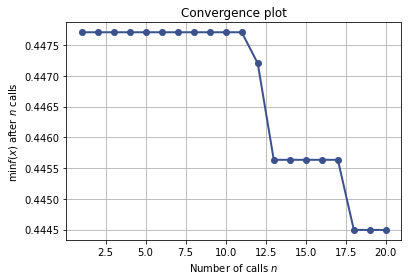

In [33]:
_ = plot_convergence(regr.optimizer_results_[0])
plt.show()

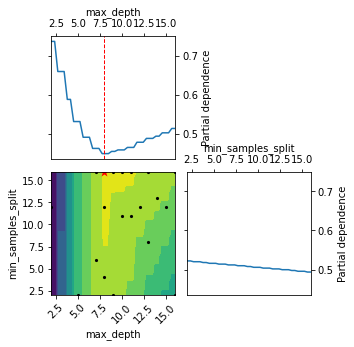

In [34]:
_ = plot_objective(regr.optimizer_results_[0],
                   dimensions=['max_depth', 'min_samples_split'],
                   n_minimum_search=int(1e8))
plt.show()

In [35]:
#### MODEL BASED OPTIMIZATION (BAYESIAN OPTIMIZATION) WITH LISTS OF SPACES

In [36]:
from skopt import BayesSearchCV
from skopt.space import Integer, Real, Categorical
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor


pipe = Pipeline([
    ('model', DecisionTreeRegressor())
])


# Search space for DT
param_grid1 = {
    'model': [DecisionTreeRegressor()],
    'model__max_depth': Integer(2,16),
    'model__min_samples_split': Integer(2,16)}

# Search space for KNN
param_grid2 = {
    'model': [KNeighborsRegressor()],
    'model__n_neighbors': Integer(2,10)
    
}

# List of the two spaces
param_grid = [param_grid1, param_grid2]

inner = KFold(n_splits=3, shuffle=True, random_state=42)

budget = 20
refr = BayesSearchCV(pipe, 
                    param_grid,
                    scoring='neg_mean_squared_error',
                    cv=inner,    
                    n_jobs=1, verbose=1,
                    n_iter=budget
                    )

np.random.seed(42)
regr.fit(X=X_train, y=y_train)



Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fi

BayesSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=True),
              estimator=DecisionTreeRegressor(), n_iter=20,
              scoring='neg_mean_squared_error',
              search_spaces={'max_depth': Integer(low=2, high=16, prior='uniform', transform='normalize'),
                             'min_samples_split': Integer(low=2, high=16, prior='uniform', transform='normalize')},
              verbose=1)

In [37]:
# At this point, regr contains the model with the best hyper-parameters found by bayessearch
# and trained on the complete X_train

# Now, the performance of regr is computed on the test partition

y_test_pred = regr.predict(X_test)
print(metrics.mean_squared_error(y_test, y_test_pred))


0.44338126428845726


In [38]:
regr.best_params_, -regr.best_score_

(OrderedDict([('max_depth', 8), ('min_samples_split', 16)]),
 0.4444940417968162)